<a href="https://colab.research.google.com/github/kunalavghade/Ai/blob/main/Week_6_%E2%80%94_Generalization%2C_Regularization_%26_Mini_Batch_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 6 — Generalization, Regularization & Mini-Batch Training

## Goal

Understand:
- Why models overfit
- How to control complexity
- How mini-batch training changes optimization
- The bias–variance tradeoff
- How regularization improves generalization

By the end of this week, you should:
- Implement mini-batch gradient descent
- Implement L2 regularization
- Implement dropout (basic version)
- Diagnose overfitting
- Understand bias vs variance deeply

---

# 1. Training vs Generalization

Training loss tells you:
> How well the model fits seen data.

But the real goal is:
> Perform well on unseen data.

Generalization is the core objective of machine learning.

---

# 2. Overfitting

Overfitting happens when:
- Training loss decreases
- Validation loss increases

The model memorizes noise instead of learning structure.

Symptoms:
- Very low training error
- High validation error

Cause:
- Model too complex
- Too many parameters
- Insufficient data

---

# 3. Underfitting

Underfitting happens when:
- Both training and validation error are high

Cause:
- Model too simple
- Poor optimization
- Not enough capacity

---

# 4. Bias–Variance Tradeoff

Bias:
- Error due to overly simple assumptions

Variance:
- Error due to sensitivity to training data

Tradeoff:
- High bias → underfitting
- High variance → overfitting

Good models balance both.

---

# 5. Mini-Batch Gradient Descent

Previously:
- You used full-batch gradient descent

Mini-batch:
- Split data into small batches (e.g., 32, 64)

Benefits:
- Faster updates
- Noisy gradients help escape saddle points
- Better scalability

Update rule remains the same — but computed per batch.

---

# 6. L2 Regularization (Weight Decay)

Add penalty to loss:

L_total = L_data + λ Σ ||W||²

Effect:
- Penalizes large weights
- Encourages simpler models
- Reduces overfitting

Gradient modification:

∂L/∂W += 2λW

---

# 7. Dropout

Idea:
- Randomly deactivate neurons during training

Effect:
- Prevents co-adaptation
- Forces redundancy
- Improves robustness

During inference:
- Use full network (scaled activations)

---

# 8. Early Stopping

Technique:
- Stop training when validation loss starts increasing

Acts as:
- Implicit regularization

---

# 9. Train / Validation Split

Proper workflow:
1. Split dataset
2. Train on training set
3. Tune hyperparameters on validation set
4. Never touch test set until final evaluation

---

# 10. Why Regularization Works

Large weights:
- Create sharp decision boundaries
- Sensitive to small input changes

Regularization:
- Smooths decision boundary
- Improves stability

---

# Coding Exercises (NumPy Only)

## Question 1: Mini-Batch Training

Modify your MLP:
- Implement batch loader
- Shuffle data each epoch
- Train using batch updates

Compare:
- Full batch vs mini-batch loss curves

---

## Question 2: L2 Regularization

Add L2 penalty to:
- Loss
- Gradients

Experiment:
- λ = 0
- Small λ
- Large λ

Plot:
- Training vs validation loss

---

## Question 3: Overfitting Experiment

Create:
- Small dataset
- Large network

Observe:
- Overfitting behavior

Plot:
- Train loss
- Validation loss

---

## Question 4: Implement Dropout

Add dropout to hidden layers:
- During training only
- Disable during evaluation

Compare:
- With dropout
- Without dropout

---

## Question 5: Bias–Variance Analysis

Create:
- Small network (low capacity)
- Large network (high capacity)

Compare:
- Training loss
- Validation loss

Explain results.

---

## Question 6: Early Stopping

Implement:
- Validation monitoring
- Stop training when validation loss increases

---

# Conceptual Questions (Write Answers)

1. Why does mini-batch training improve generalization?
2. Why does L2 reduce model complexity?
3. Why does dropout act like model averaging?
4. What is the difference between regularization and optimization?
5. Why does early stopping work?

---

# Outcome of Week 6

After completing this week, you should:
- Understand generalization deeply
- Diagnose overfitting confidently
- Control model complexity
- Train models responsibly
- Think like a researcher, not just a coder


Imports

In [3]:
import numpy as np
import matplotlib.pyplot as plt

Train / Validation Split

In [4]:
def train_val_split(X, y, val_ratio=0.2):
    indices = np.random.permutation(len(X))
    split = int(len(X) * (1 - val_ratio))

    train_idx = indices[:split]
    val_idx = indices[split:]

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]


Activation Functions

In [5]:
def relu(z):
  return np.maximum(z, 0)

def relu_derivative(z):
  return (z > 0).astype(float)

def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def simoid_derivative(z):
  s = sigmoid(z)
  return s * (1 - s)

Initialize Parameters

In [6]:
def initialize(layers):
    params = {}
    for l in range(1, len(layers)):
        params[f"W{l}"] = np.random.randn(layers[l-1], layers[l]) * np.sqrt(2/layers[l-1])
        params[f"b{l}"] = np.zeros((1, layers[l]))
    return params


Forward Pass (With Dropout)
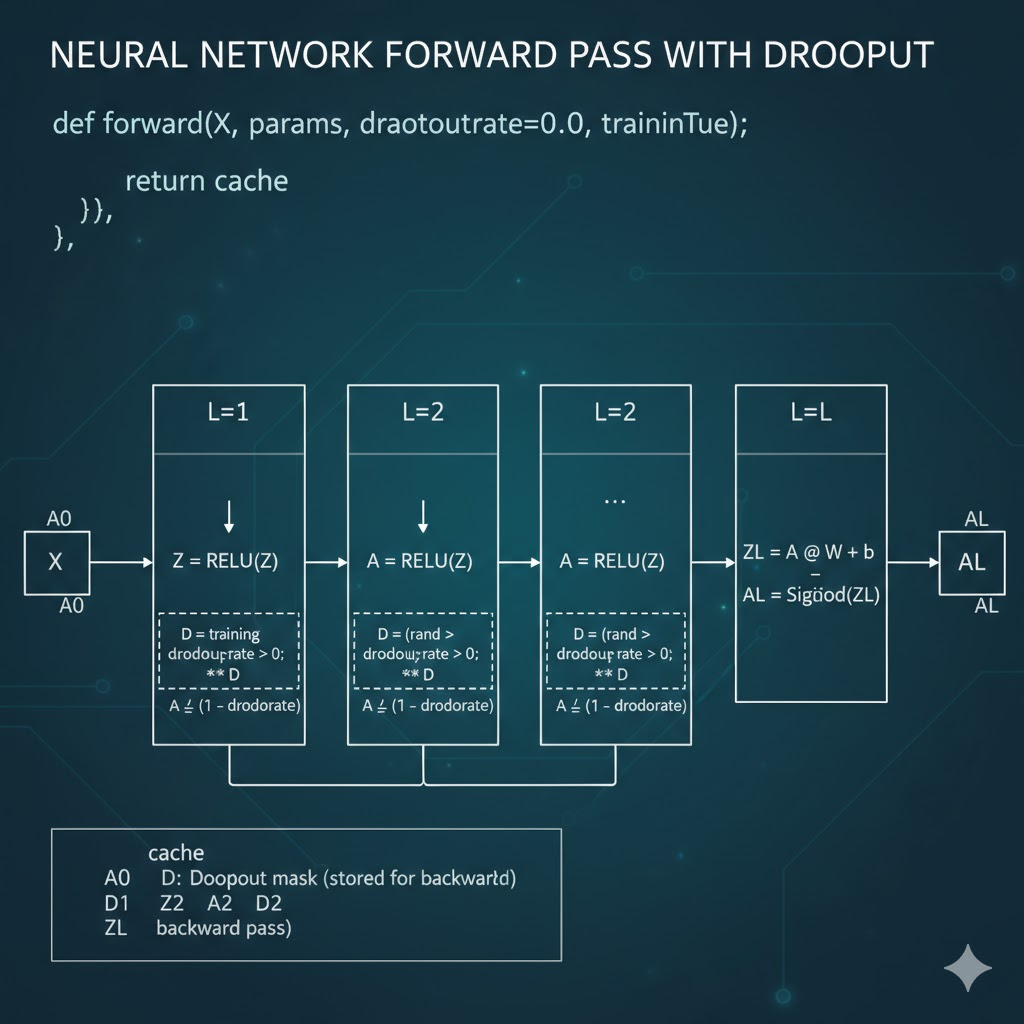

In [7]:
def forward(X, params, dropout_rate=0.0, training=True):
    cache = {"A0": X}
    A = X
    L = len(params)//2

    for l in range(1, L):
        Z = A @ params[f"W{l}"] + params[f"b{l}"]
        A = relu(Z)

        if training and dropout_rate > 0:
            D = (np.random.rand(*A.shape) > dropout_rate).astype(float)
            A *= D
            A /= (1 - dropout_rate)
            cache[f"D{l}"] = D

        cache[f"A{l}"] = A
        cache[f"Z{l}"] = Z

    ZL = A @ params[f"W{L}"] + params[f"b{L}"]
    AL = sigmoid(ZL)

    cache[f"A{L}"] = AL
    cache[f"Z{L}"] = ZL

    return AL, cache


Compute Loss (With L2)

In [8]:
MIN = 1e-8

def compute_loss(y, y_hat, params, l2_lamba=0):
  m = y.shape[0]

  data_loss = -np.mean(y * np.log(y_hat+MIN) + (1-y) * np.log(1 - y_hat+MIN))

  l2_loss = 0
  for key in params:
    if "W" in key:
      l2_loss += np.sum(params[key] ** 2)

  l2_loss *= l2_lamba / (2 * m)

  return data_loss + l2_loss

Backward Pass (With L2 + Dropout)
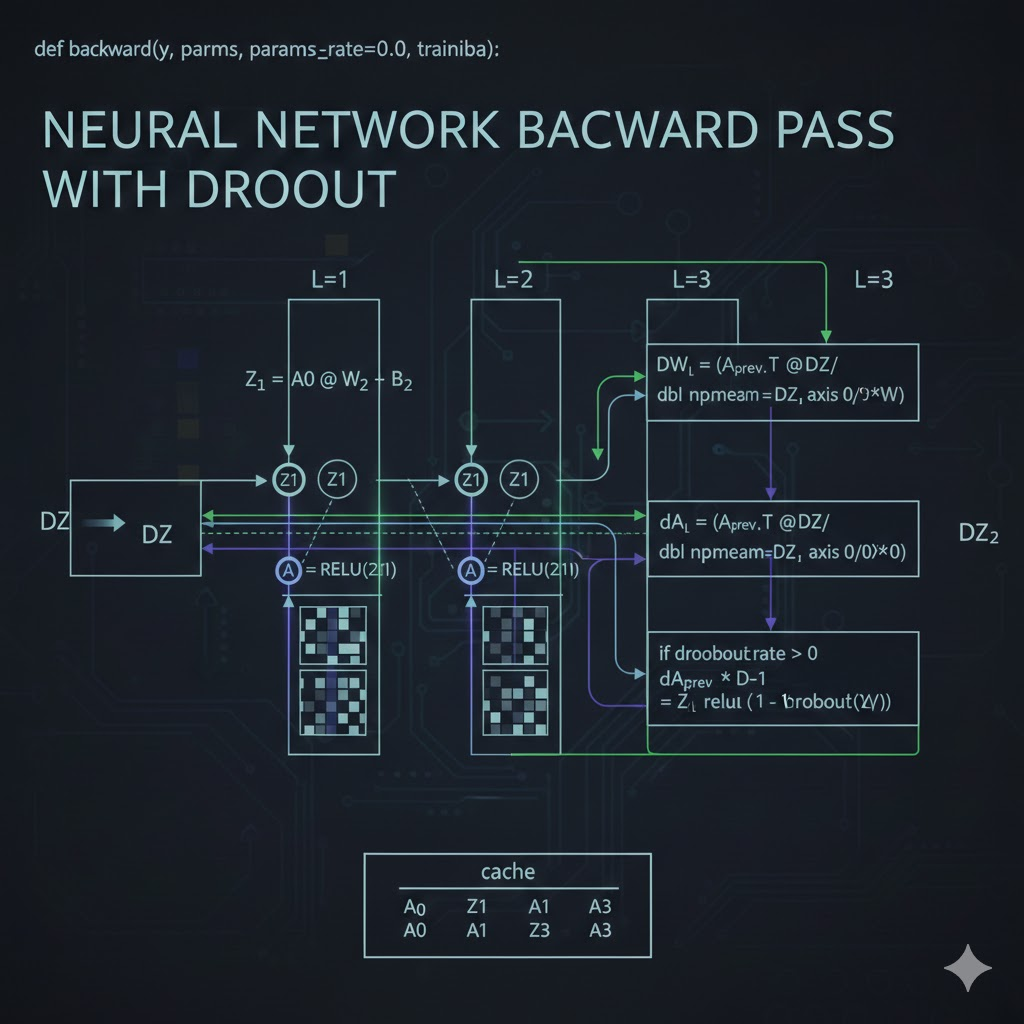

In [9]:
def backward(y, params, cache, l2_lambda=0, dropout_rate=0.0):

  grads = {}
  L = len(params)//2
  m = y.shape[0]

  dz = cache[f"Z{L}"] - y

  for l in reversed(range(1, L+1)):
    A_prev = cache[f"A{l-1}"]

    grads[f'dW{l}'] = (A_prev.T @ dz) / m + (l2_lambda /m) * params[f'W{l}']
    grads[f'db{l}'] = np.mean(dz, axis=0, keepdims=True)

    if l > 1:
      dA_prev = dz @ params[f'W{l}'].T

      if dropout_rate > 0:
        dA_prev *= cache[f'D{l-1}']
        dA_prev /= 1 - dropout_rate

      dz = dA_prev * relu_derivative(cache[f"Z{l-1}"])

  return grads

Update Parameters

In [10]:
def update(params, grads, lr):
  for key in params:
    params[key] -= lr * grads[f'd{key}']
  return params

Mini-Batch Loader

In [11]:
def create_batches(X, y, batch_size):
    indices = np.random.permutation(len(X))
    X_shuffled = X[indices]
    y_shuffled = y[indices]

    for i in range(0, len(X), batch_size):
        yield X_shuffled[i:i+batch_size], y_shuffled[i:i+batch_size]


Training Function (With Early Stopping)

In [12]:

def train_model(X, y, layers, epochs=1000, lr = 0.01, batch_size=32, l2_lambda = 0, dropout_rate=0, early_stopping=False):
  params = initialize(layers)

  X_train, y_train, X_val, y_val = train_val_split(X, y)

  train_losses, val_losses = [], []

  best_val, patience, counter = float('inf'), 5, 0

  for epoch in range(epochs):

    #batch training of model
    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
      # train
      y_hat, cache = forward(X_batch, params, dropout_rate, training=True)
      # calculate grad
      grads = backward(y_batch, params, cache, l2_lambda, dropout_rate)
      # update weight and biases
      params = update(params, grads, lr)

    # predict
    train_pred, _ = forward(X_train, params, training=False)
    val_pred, _ = forward(X_val, params, training=False)

    # calculate losses
    train_loss = compute_loss(y_train, train_pred, params, l2_lambda)
    val_loss = compute_loss(y_val, val_pred, params, l2_lambda)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if early_stopping:
      if val_loss < best_val:
        best_val = val_loss
        counter = 0
      else:
        counter += 1
        if counter >= patience:
          print(f"Early stopping at epoch {epoch+1}")
          break

  return params, train_losses, val_losses


**Question 3 — Overfitting Example**

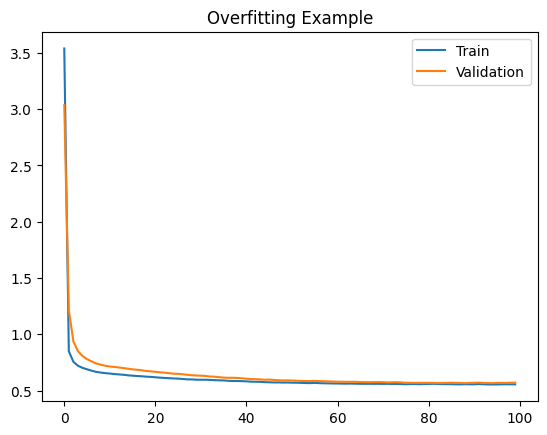

In [13]:
np.random.seed(42)

X = np.random.randn(60, 2)
y = (X[:,0]*X[:,1] > 0).astype(float).reshape(-1,1)

layers = [2, 128, 128, 1]

params, train_loss, val_loss = train_model(
    X, y, layers,
    epochs=100,
    lr=0.05,
    l2_lambda=0,
    dropout_rate=0
)

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.title("Overfitting Example")
plt.show()


**Question 4 — Add Regularization**

/tmp/ipython-input-3298574709.py:8: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))
/tmp/ipython-input-1206546293.py:12: RuntimeWarning: overflow encountered in matmul
  grads[f'dW{l}'] = (A_prev.T @ dz) / m + (l2_lambda /m) * params[f'W{l}']
/tmp/ipython-input-1206546293.py:16: RuntimeWarning: overflow encountered in matmul
  dA_prev = dz @ params[f'W{l}'].T
/tmp/ipython-input-1206546293.py:19: RuntimeWarning: invalid value encountered in multiply
  dA_prev *= cache[f'D{l-1}']
/tmp/ipython-input-1206546293.py:20: RuntimeWarning: overflow encountered in divide
  dA_prev /= 1 - dropout_rate
/tmp/ipython-input-1206546293.py:22: RuntimeWarning: invalid value encountered in multiply
  dz = dA_prev * relu_derivative(cache[f"Z{l-1}"])
/tmp/ipython-input-1206546293.py:12: RuntimeWarning: invalid value encountered in matmul
  grads[f'dW{l}'] = (A_prev.T @ dz) / m + (l2_lambda /m) * params[f'W{l}']
/tmp/ipython-input-2469347901.py:7: RuntimeWarning: overflow encountere

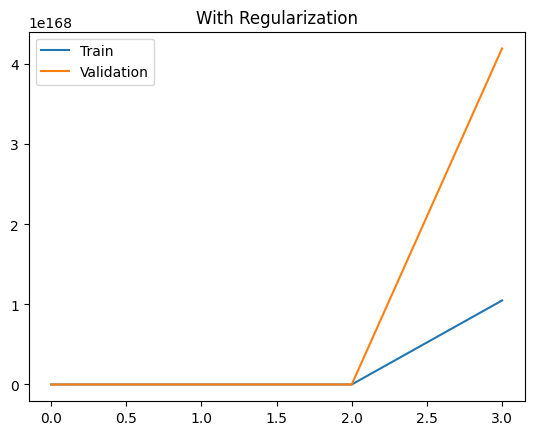

In [14]:
params, train_loss, val_loss = train_model(
    X, y, layers,
    epochs=500,
    lr=0.05,
    l2_lambda=0.01,
    dropout_rate=0.5
)

plt.plot(train_loss, label="Train")
plt.plot(val_loss, label="Validation")
plt.legend()
plt.title("With Regularization")
plt.show()


**Question 5 — Bias vs Variance**

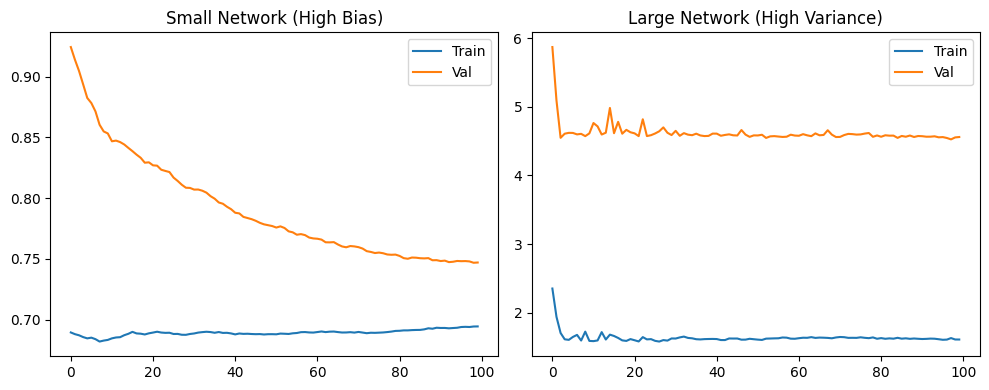

In [18]:
layers_small = [2,4,1]          # High bias
layers_large = [2,256,256,1]    # High variance

_, train_small, val_small = train_model(
    X, y, layers_small,
    epochs=100,
    lr=0.01,
    l2_lambda=0.1,
    dropout_rate=0.5
)

_, train_large, val_large = train_model(
    X, y, layers_large,
    epochs=100,
    lr=0.01,
    l2_lambda=0.1,
    dropout_rate=0.5
)

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_small,label="Train")
plt.plot(val_small,label="Val")
plt.title("Small Network (High Bias)")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_large,label="Train")
plt.plot(val_large,label="Val")
plt.title("Large Network (High Variance)")
plt.legend()

plt.tight_layout()
plt.show()


